In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

%matplotlib inline

import re
plt.style.use('dark_background')

In [2]:
pre_merged = pd.read_csv('./Unmerged Data/Pre_Merged_Data.csv', encoding='latin-1')
crime = pd.read_csv('./Unmerged Data/Other Data/CrimeOneYearofData.csv', encoding='latin-1')
exp_per_pupil = pd.read_csv('C:\\Users\\Mark\\GA\\Projects\\project-3\\Unmerged Data\\School Data\\expenditure_per_pupil_SS1300A18.dat', sep='|', encoding='latin-1')

# rename stat column for merging and capatilize state name
crime.rename(columns={'State':'state_crime'}, inplace=True)

crime['state_crime'] = crime['state_crime'].str.upper()

# expense per pupil renaming columns and removing blank columns
per_pupil_renamed    = ['geotype', 'st', 'geo_id', 'geo_ttl', 'year', 'enroll_per_pupil', 'total_expnd_per_pupil',
                        'objects_salary_wage_per_pupil', 'objects_employee_benefits_per_pupil',
                        'instruction_total_per_pupil', 'instruction_salary_wages_per_pupil', 
                        'instruction_employee_benefits_per_pupil', 'suport_services_total_per_pupil', 
                        'pupil_support_per_pupil', 'instruction_staff_support_per_pupil', 
                        'services_general_admin_per_pupil', 'services_school_admin_per_pupil']

exp_per_pupil = exp_per_pupil.dropna(axis=1)

exp_per_pupil.columns = per_pupil_renamed

## Cleaning

In [3]:
df_names = [pre_merged, crime]
for i in df_names:
    i.rename(columns= {col: col.lower() for col in i.columns}, inplace=True)

In [4]:
def rate_cleaner2(i):
    try:
        left , right = i.split('-')
        return round((int(left)+int(right))/2)
        
    except:
        if pd.isnull(i):
            return np.nan
        
        if i[0] == 'L':
            return round(int(i[2:])/2)
            
        if i[0] == 'G':
            return round((int(i[2:]) + 100) / 2)

        if i == 'PS':
            return np.nan
        
        if i.isnumeric():
            return int(i)
        
def money_cleaner(cell):    
    if pd.isnull(cell):
        return int('0')
    else:
        return int(cell.replace(',' , '').strip('$'))

In [5]:
list_columns = [i for i in pre_merged.columns[7:24] if 'rate' in i]
for i in list_columns:
    pre_merged[i] = pre_merged[i].apply(rate_cleaner2)

money_col = ['med_hhd_inc_acs_08_12', 'med_hhd_inc_acsmoe_08_12', 'aggregate_hh_inc_acs_08_12', 'aggregate_hh_inc_acsmoe_08_12', 'med_house_value_acs_08_12',
     'med_house_value_acsmoe_08_12', 'aggr_house_value_acs_08_12', 'aggr_house_value_acsmoe_08_12']
for i in money_col:
    pre_merged[i] = pre_merged[i].apply(money_cleaner)

In [6]:
# Calcualte Percentage of students that are economically disadvantaged
pre_merged['Econ_Disadv_Percent'] = pre_merged['ecd_cohort_1112'] / pre_merged['all_cohort_1112']

## Merging Crime and Expenses

In [7]:
school_id_per_pupil = []
for i in exp_per_pupil['geo_id']:
    school_id_per_pupil.append(int(i.split('US')[1]))

exp_per_pupil['leaid'] = school_id_per_pupil

In [8]:
merged_df = pd.merge(pre_merged, exp_per_pupil[['leaid', 'instruction_salary_wages_per_pupil']], how='left', left_on='leaid11', right_on='leaid').drop('leaid', axis=1)

In [9]:
merged_df = pd.merge(merged_df, crime[['state_crime', 'population', 'violent crime total', 'property crime total', 'violent crime rate', 'property crime rate']],
         how='left', left_on='stnam', right_on='state_crime').drop('state_crime', axis=1)

### Prep Merged Data for Modeling

In [10]:
merged_df = merged_df.rename(columns={
    'pct_othr_lang_acs_08_12': 'English_Second_Lang',
    'pct_age5p_only_eng_acs_08_12': 'English_Primary',
    'med_hhd_inc_acs_08_12': 'Median_HH_Income',
    'pct_prs_blw_pov_lev_acs_08_12': 'Percent_Below_Poverty_Line',
    'all_rate_1112': 'Grad_Rates',
    'all_cohort_1112': 'Class_Size',
})

In [11]:
df = merged_df.copy()
columns_to_drop = [i for i in df.columns if 'age5p' in i or
                   'othr_lang' in i or
                   'eng_vw' in i or
                   'rate' in i or
                   'cohort' in i or
                   'mobile_homes' in i or
                   'unnamed' in i
]

df = df.drop(columns_to_drop, axis=1)

## Model

In [12]:
X = df.drop(df.columns[:20], axis=1)
y = df['Grad_Rates']

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.43454467378634809

In [15]:
rf_features_df = pd.DataFrame()
rf_features_df['importances'] = rf.feature_importances_
rf_features_df['features'] = X.columns
rf_features_df.sort_values('importances', ascending=False).head(10)

,importances,features
0,0.179457,land_area
355,0.137793,Econ_Disadv_Percent
356,0.109991,instruction_salary_wages_per_pupil
358,0.017361,violent crime total
357,0.010007,population
359,0.008199,property crime total
224,0.006918,pct_nh_white_alone_cen_2010
332,0.005346,pct_single_unit_acsmoe_08_12
225,0.004965,pct_nh_white_alone_acs_08_12
157,0.004846,owner_occp_hu_cen_2010


## Feature Exploration/EDA

In [16]:
# looking into the realtionships between graduation rate and the most correlated features
sig_feat = df[['Grad_Rates', 'Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'pct_vacant_units_cen_2010', 'violent crime total',
               'pct_tot_occp_units_cen_2010', 'property crime total', 'population']]
sig_feat = sig_feat.fillna(0)

In [17]:
sig_feat.corr()

,Grad_Rates,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,pct_vacant_units_cen_2010,violent crime total,pct_tot_occp_units_cen_2010,property crime total,population
Grad_Rates,1.000000,-0.374866,-0.131401,-0.281058,0.105616,0.249445,0.106836,0.130542
Econ_Disadv_Percent,-0.374866,1.000000,-0.193408,0.214865,0.136941,-0.193848,0.150733,0.092397
instruction_salary_wages_per_pupil,-0.131401,-0.193408,1.000000,0.118918,-0.001218,-0.100682,-0.089551,0.034275
pct_vacant_units_cen_2010,-0.281058,0.214865,0.118918,1.000000,-0.020423,-0.822683,-0.010852,-0.037386
violent crime total,0.105616,0.136941,-0.001218,-0.020423,1.000000,0.003432,0.954184,0.988026
pct_tot_occp_units_cen_2010,0.249445,-0.193848,-0.100682,-0.822683,0.003432,1.000000,-0.002839,0.024781
property crime total,0.106836,0.150733,-0.089551,-0.010852,0.954184,-0.002839,1.000000,0.947364
population,0.130542,0.092397,0.034275,-0.037386,0.988026,0.024781,0.947364,1.000000


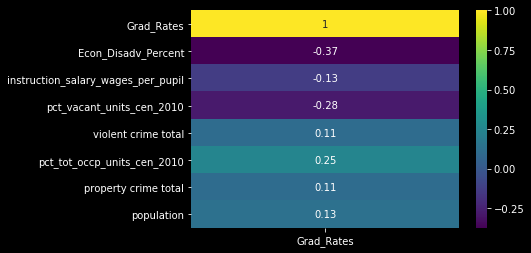

In [18]:
sns.heatmap(sig_feat.corr()[['Grad_Rates']], annot=True, cmap='viridis')

C:\Users\Mark\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


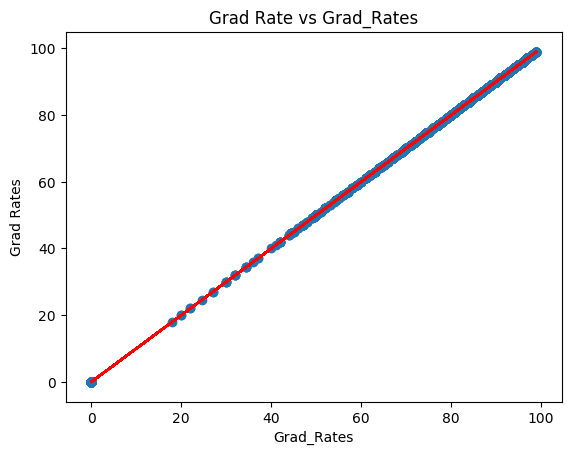

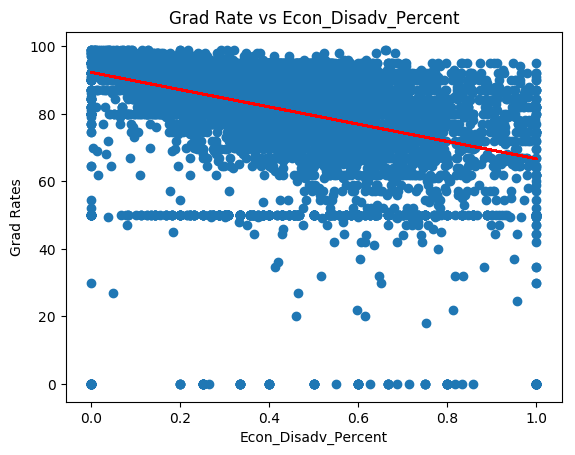

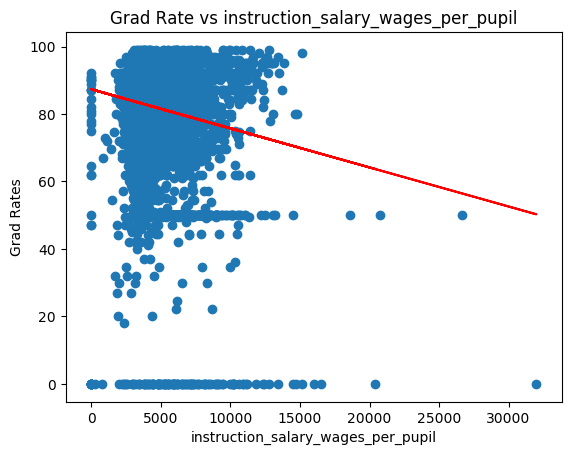

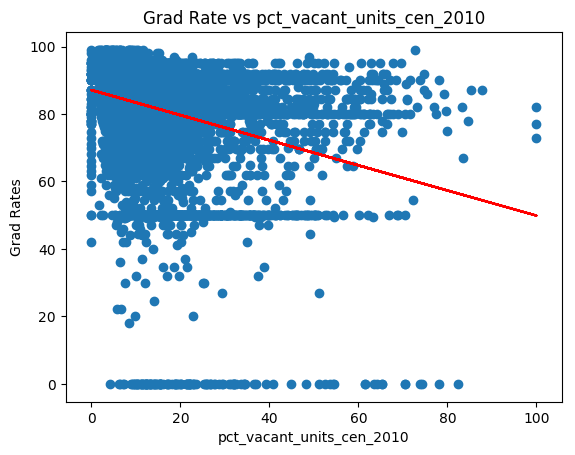

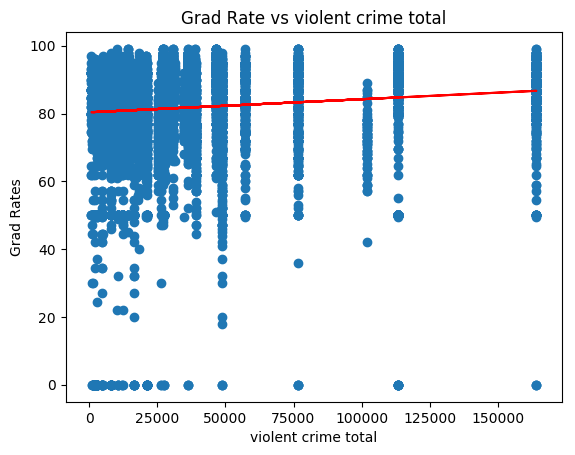

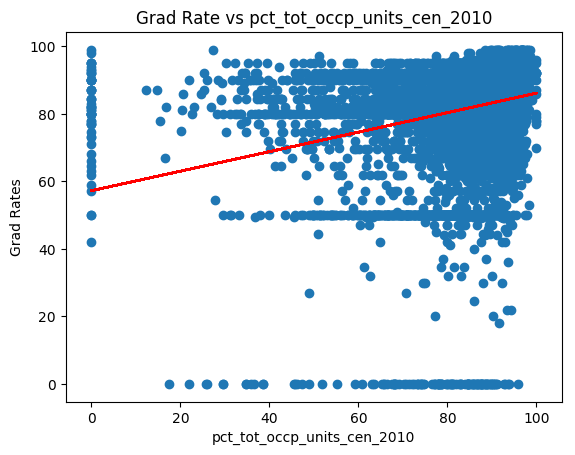

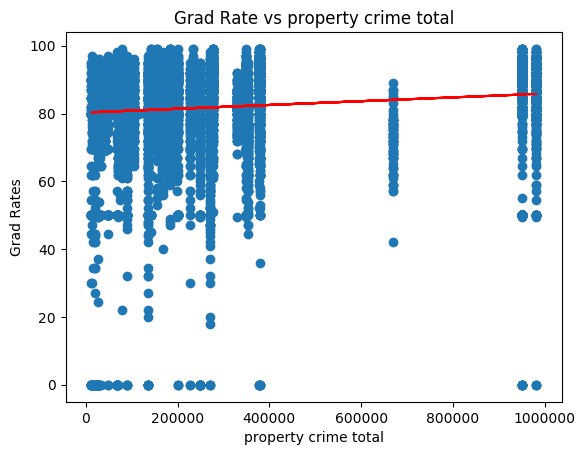

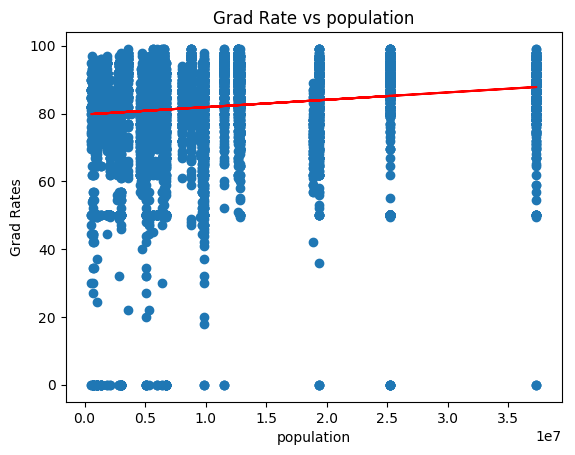

In [19]:
sig_feat_list = ['Grad_Rates', 'Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'pct_vacant_units_cen_2010', 'violent crime total',
               'pct_tot_occp_units_cen_2010', 'property crime total', 'population']

for i in sig_feat_list:
    plt.style.use('default')
    
    x = sig_feat[i]
    y = sig_feat['Grad_Rates']

    fig, ax = plt.subplots()
    reg_line = np.polyfit(x, y, deg=1)
    ax.plot(x, reg_line[0] * x + reg_line[1], color='red')
    ax.scatter(x, y)

    plt.title(f'Grad Rate vs {i}')
    plt.xlabel(i)
    plt.ylabel('Grad Rates')
    
    fig.show()

## Predicting How Changes Effect Graduation Rate

In [20]:
def current_rates(state='California', school='Cuyama Joint Unified', df=df):
    """Find your existing rates and correlated values"""
    state_name = state.upper()
    df = df[df['stnam'] == state_name]
    
    adjustments = df[df['leanm11'] == school].copy()
    adjust_feat = ['leanm11', 'Grad_Rates', 'Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'violent crime total', 'property crime total']
    return adjustments[adjust_feat]

In [21]:
def improvements(state='California', school='Cuyama Joint Unified', disadv_pct=1, salary=2, violent_crime=3, property_crime=4, df=df):
    """Find your new graduation rate based on changes to correlated values"""
#     Select the state name for the school
    state_name = state.upper()
    df = df[df['stnam'] == state_name]
    
#     Create a model for that state
    X = df.drop(df.columns[:20], axis=1)
    y = df['Grad_Rates']
    X = X.fillna(0)
    y = y.fillna(0)
    
    rf = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1, random_state=101)
    rf.fit(X, y)
#     scores = cross_val_score(rf,X,y, n_jobs=-1)
    
#     Create a DF for the school adjustments
    adjustments = df[df['leanm11'] == school].copy()
    adjustments = adjustments.drop(adjustments.columns[:20], axis=1)
    adjustments = adjustments.fillna(0)

#     Adjust features
    adjust_feat = ['Econ_Disadv_Percent', 'instruction_salary_wages_per_pupil', 'violent crime total', 'property crime total']
    adj_values = [disadv_pct, salary, violent_crime, property_crime]
    adj_index = adjustments.index[0]
    for i in adjust_feat:
        adjustments.set_value(index=adj_index ,col=adjust_feat, value=adj_values)

#     Make predictions from adjustments    
    new_grad_rate = round(rf.predict(adjustments)[0])
    old_grad_rate = df[df['leanm11'] == school]['Grad_Rates'].iloc[0]   
    
    return print(f'\nYour new graduation rate is {new_grad_rate}% \nYour old graduation rate was {old_grad_rate}%')

In [22]:
current_rates('california', 'Compton Unified')

,leanm11,Grad_Rates,Econ_Disadv_Percent,instruction_salary_wages_per_pupil,violent crime total,property crime total
648,Compton Unified,57.0,0.844272,3743.0,164133,981939


In [23]:
improvements('california', 'Compton Unified', disadv_pct=0.144272, salary=3743, violent_crime=164133, property_crime=981939)


Your new graduation rate is 93.0% 
Your old graduation rate was 57.0%
